## Setup

In [1]:
import math

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The class imbalance is shown below, with benign URLs consisting of the majority of the data points. Defacement and malware take second place, and phishing URLs consist of the smallest percentage of URLs.

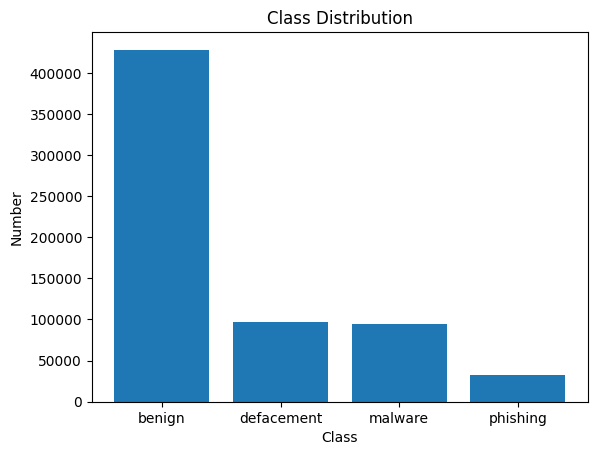

In [7]:
plt.bar(["benign", "defacement", "malware", "phishing"], [428103, 96547, 94111, 32520])
plt.xlabel("Class")
plt.ylabel("Number")
plt.title("Class Distribution")
plt.show()

## Class

I am loading the pre-trained model along with its tokenizer here.

BERT (Bi-Directional Pre-Trained Transformer) uses the encoder part of a transformer. This model is pre-trained under the MLM (masked language modeling) task on lots of data from the Internet. Therefore, the model has a good understanding of English grammar.

BERT is not trained in the classification task I want to perform, so I have to perform fine-tuning for BERT on a sample of the URL data.

This model does not need a large amount of data to fine-tune.

Each model has its own tokenizer because they each accept data in their own specific formats.

I am running this model on the SJSU HPC (High-Performance Cluster) servers, so I had to download the model from HuggingFace to use locally

The URLs need to be converted into numbers, so I use the BERT tokenizer here to convert the inputs into a format that BERT can recognize.

BERT uses a WordPiece tokenizer [4]. It uses the following formula to figure out what tokens pairs to merge together [4]:
$$
\text{score} = \frac{\text{freq\_of\_pair}}{\text{freq\_of\_first\_element} \times \text{freq\_of\_second\_element}}
$$

It creates a library of tokens so that it can generalize to unseen words [4].

The formula above differentiates it from a more classic tokenization algorithm called BPE (byte-pair encoding), which only looks at the frequencies of token pairs [4].

The cell below is one method for dealing with a class imbalance. The code groups up the rows by their class (benign, defacement, etc.) and sums up the counts for each class [3]. The division by 1 normalizes the counts. [3]

This object specifies the training configuration arguments.

The `output_dir` parameter specifies the directory where the model checkpoints will be stored. Model checkpoints store the model weights at predefined increments. 

The `num_train_epochs` parameter specifies the number of epochs that the model will train for. Each epoch goes through all of the batches of training data.

The `learning_rate` parameter controls how fast or how slow the model will learn. A higher learning rate will cause the model to converge faster, but a slower learning rate will slow down the model learning and lessen overfitting.

The `per_device_train_batch_size` parameter controls how large each batch of data is. 

In [2]:
class BERTClass():

    def __init__(self, original_df, num_samples, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=4)
        
        self.original_df = original_df
        self.num_samples = num_samples
        
        self.dataset = self.preprocess()
        
        train_dataset, eval_dataset, test_dataset = self.split_data()

        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.test_dataset = test_dataset

    # helper function
    def convert_to_HF(self, df):
        dataset = Dataset.from_pandas(df)
        if "__index_level_0__" in list(dataset.features.keys()):
            dataset = dataset.remove_columns(["__index_level_0__"])
        dataset = dataset.class_encode_column("type")
        
        dataset = dataset.rename_column("url", "text")
        dataset = dataset.rename_column("type", "label")
    
        return dataset

    # helper function
    def tokenize(self, data):
        return self.tokenizer(data["text"], padding="max_length", return_tensors="pt")
    
    def preprocess(self): 
        weights = 1.0 / self.original_df.groupby('type')['type'].transform('count')
        
        df = original_df.sample(n=self.num_samples, replace=False, random_state=42, weights=weights)

        dataset = self.convert_to_HF(df)
        
        tokenized_dataset = dataset.map(self.tokenize, batched=True)

        self.target_labels = dataset.features["label"].names

        return tokenized_dataset

    # helper function
    def split_data(self):
        split_dataset = self.dataset.train_test_split(test_size=0.1)
        
        train_eval_dataset = split_dataset["train"]
        
        train_eval_split_dataset = train_eval_dataset.train_test_split(test_size=0.1)

        train_dataset = train_eval_split_dataset["train"]
    
        eval_dataset = train_eval_split_dataset["test"]

        test_dataset = split_dataset["test"]

        return (train_dataset, eval_dataset, test_dataset)

    # helper function
    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        sum = 0
        for i in range(len(labels)):
            raw_logits = logits[i]
            
            exp_logits = np.exp(raw_logits)
            norm_logits = exp_logits / np.sum(exp_logits, axis=0)
            chosen_value = norm_logits[labels[i]]
            
            sum += np.log(chosen_value)
        sum /= -len(labels)
        return {"cross_entropy": sum}
    
    def train(self, num_train_epochs, logging_steps, learning_rate, per_device_train_batch_size, weight_decay):
        training_args = TrainingArguments(output_dir="results", 
                                          num_train_epochs=num_train_epochs,
                                          logging_steps=logging_steps,
                                          learning_rate=learning_rate,
                                          per_device_train_batch_size=per_device_train_batch_size,
                                          weight_decay=weight_decay,
                                          evaluation_strategy="epoch"
                                         )

        self.trainer = Trainer(model=self.model,
                          args=training_args,
                          train_dataset=self.train_dataset,
                          eval_dataset=self.eval_dataset,
                          compute_metrics=self.compute_metrics,
                        )

        self.trainer.train()

    def evaluate(self):
        predictions = self.trainer.predict(self.test_dataset)
        predicted_labels = np.argmax(predictions.predictions, axis=-1)
        true_labels = self.test_dataset["label"]
        
        conf_mat = confusion_matrix(true_labels, predicted_labels, labels=np.arange(4))
        
        plt.figure(figsize=(7, 4))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=self.target_labels, yticklabels=self.target_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        report = classification_report(true_labels, predicted_labels, labels=np.arange(4), target_names=self.target_labels, output_dict=False)
        print(report)

## Load in the Data

In [3]:
original_df = pd.read_csv("malicious_phish.csv")
original_df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
bert = BERTClass(original_df, 1000, "./bert-base-uncased/")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./bert-base-uncased/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 2644.24 examples/s]


In [5]:
bert.train(num_train_epochs=5,
          logging_steps=1,
          learning_rate=5e-5,
          per_device_train_batch_size=8,
          weight_decay=0
          )

/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Cross Entropy
1,0.440100,0.502882,0.502882
2,0.013100,0.430004,0.430004
3,0.006400,0.431930,0.431930
4,0.003400,0.475460,0.475460
5,0.002700,0.423440,0.423440


It is important to see how the model performs across the different classes. A single accuracy value averaged across all of the classes provides an insufficient evaluation of the model's performance. As mentioned earlier, there is a class imbalance. If the model boasts an accuracy of 90%, it does not provide information on the under-represented classes. Therefore, it is vital to look at the precision, recall, and F-1 score for each class. These metrics are detailed in the classification report below.

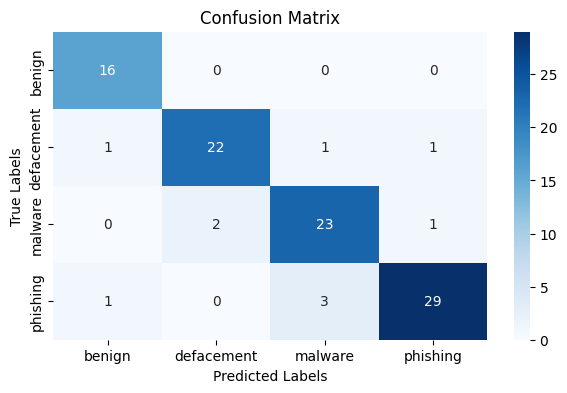

              precision    recall  f1-score   support

      benign       0.89      1.00      0.94        16
  defacement       0.92      0.88      0.90        25
     malware       0.85      0.88      0.87        26
    phishing       0.94      0.88      0.91        33

    accuracy                           0.90       100
   macro avg       0.90      0.91      0.90       100
weighted avg       0.90      0.90      0.90       100



In [6]:
bert.evaluate()